🧠 Step 1: Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import torch
import torch.nn as nn
print(torch.__version__)


2.9.1+cpu


In [4]:
device = torch.device("cpu")
print(device)

cpu


In [5]:
# print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

🧩 Step 2: Define Transformations

Transformations help resize images and normalize them for training.

In [6]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Transform (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize all images to same size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])


# Load dataset
train_dataset = datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Training", transform=transform)
test_dataset=datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Testing", transform=transform)


# Class names
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:
print(train_dataset.class_to_idx)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


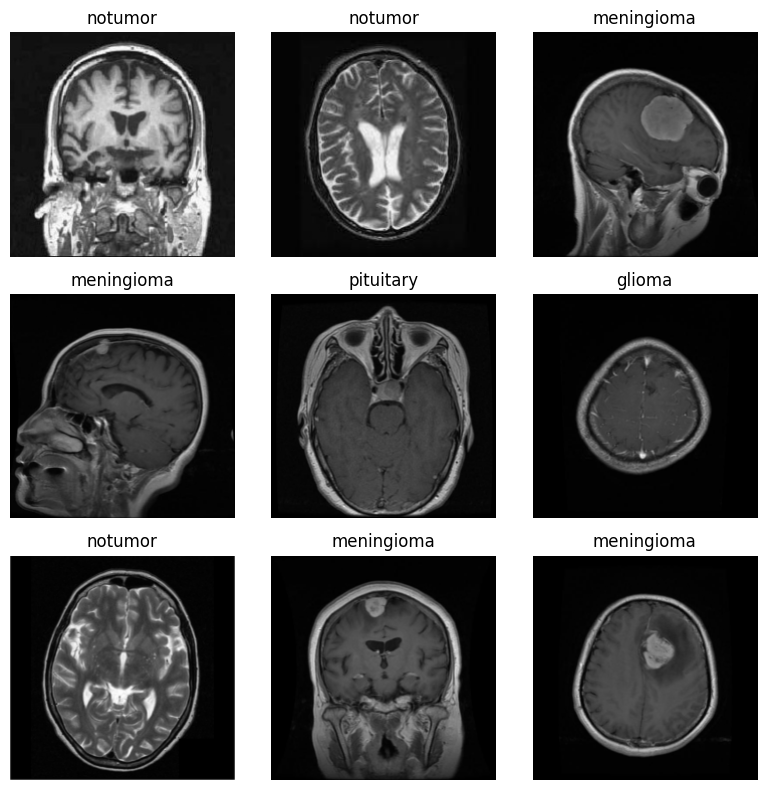

In [8]:
import random
import numpy as np

# Pick 9 random images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]
    
    # Tensor → Numpy for plotting
    img = img.permute(1, 2, 0).numpy()
    
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()



In [9]:
from collections import Counter

# Folder-wise image counts
labels = [label for _, label in train_dataset]
counter = Counter(labels)

for i, c in enumerate(classes):
    print(f"{c}: {counter[i]} images")


glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


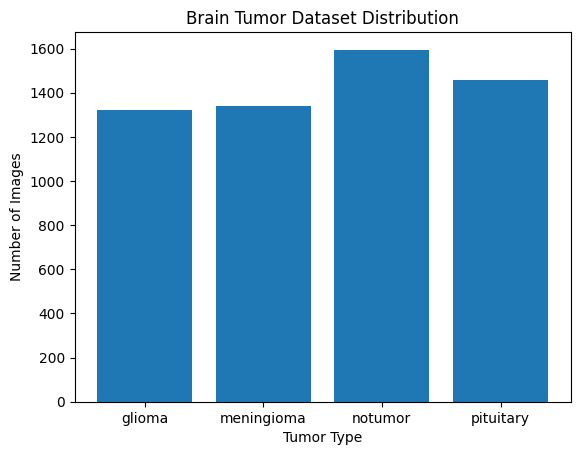

In [10]:
plt.bar(classes, [counter[i] for i in range(len(classes))])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Brain Tumor Dataset Distribution")
plt.show()


📦 Step 3: Make Datasets class

In [11]:
from torch.utils.data import DataLoader ,Dataset
from sklearn.model_selection import train_test_split



class CustomImageDataset(Dataset):
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img, label = self.image_folder[idx]
        img = self.transform(img)
        return img, label

⚙️ Step 4: Create Dataloaders

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

🧩 Step 5: Make Model Convolutional Neural Neteork

In [14]:
class CNN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding='same', stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # corrected size
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [15]:
l=len(classes)

In [16]:
model = CNN(input_channels=3)
model.to(device)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_featur

In [17]:
for param in model.parameters():
    print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 100352])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


In [18]:
learning_rate=0.001
epochs=10
batch_size=32

In [19]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [45]:
# criterion=nn.CrossEntropyLoss()
# optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [20]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    avg_train_loss = total_epoch_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_features, val_labels in test_loader:
            val_features = val_features.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_features)
            v_loss = criterion(val_outputs, val_labels)

            val_loss += v_loss.item()

            _, v_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (v_predicted == val_labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total

    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    # Print Epoch Summary
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"- Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% "
          f"- Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch [1/10] - Train Loss: 1.0760, Train Acc: 62.43% - Val Loss: 0.9253, Val Acc: 65.75%
Epoch [2/10] - Train Loss: 0.7237, Train Acc: 76.68% - Val Loss: 0.7352, Val Acc: 71.62%
Epoch [3/10] - Train Loss: 0.5694, Train Acc: 79.94% - Val Loss: 0.6070, Val Acc: 74.45%
Epoch [4/10] - Train Loss: 0.4876, Train Acc: 82.32% - Val Loss: 0.5678, Val Acc: 77.35%
Epoch [5/10] - Train Loss: 0.4291, Train Acc: 84.61% - Val Loss: 0.4753, Val Acc: 81.46%
Epoch [6/10] - Train Loss: 0.3831, Train Acc: 86.47% - Val Loss: 0.4576, Val Acc: 80.63%
Epoch [7/10] - Train Loss: 0.3441, Train Acc: 87.90% - Val Loss: 0.4616, Val Acc: 79.63%
Epoch [8/10] - Train Loss: 0.3206, Train Acc: 88.34% - Val Loss: 0.3848, Val Acc: 85.74%
Epoch [9/10] - Train Loss: 0.2890, Train Acc: 89.83% - Val Loss: 0.3434, Val Acc: 86.96%
Epoch [10/10] - Train Loss: 0.2673, Train Acc: 90.72% - Val Loss: 0.3258, Val Acc: 86.80%


In [21]:
# # Load
# Add map_location=torch.device('cpu')
# model = torch.load("model.pth", map_location=torch.device('cpu')) 
model.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_featur

Visualize the code

Plot Accuracy Graph

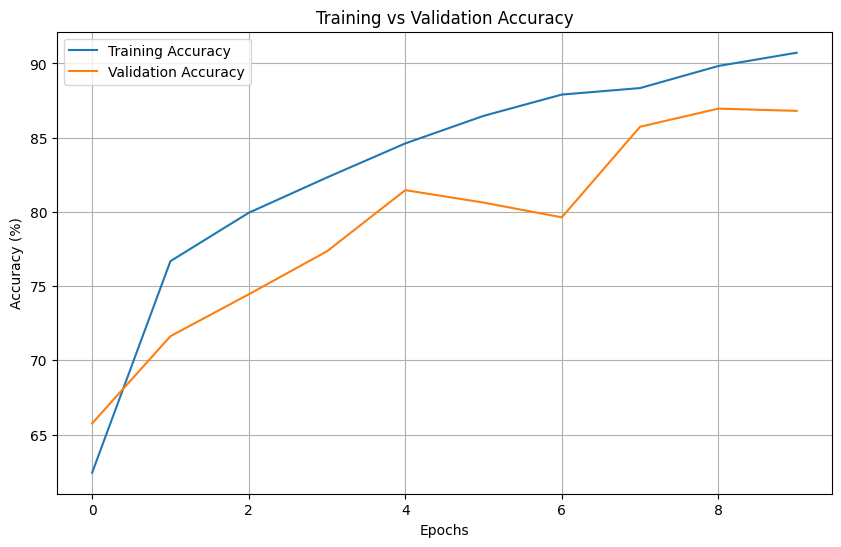

In [22]:
plt.figure(figsize=(10,6))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Plot Loss Graph

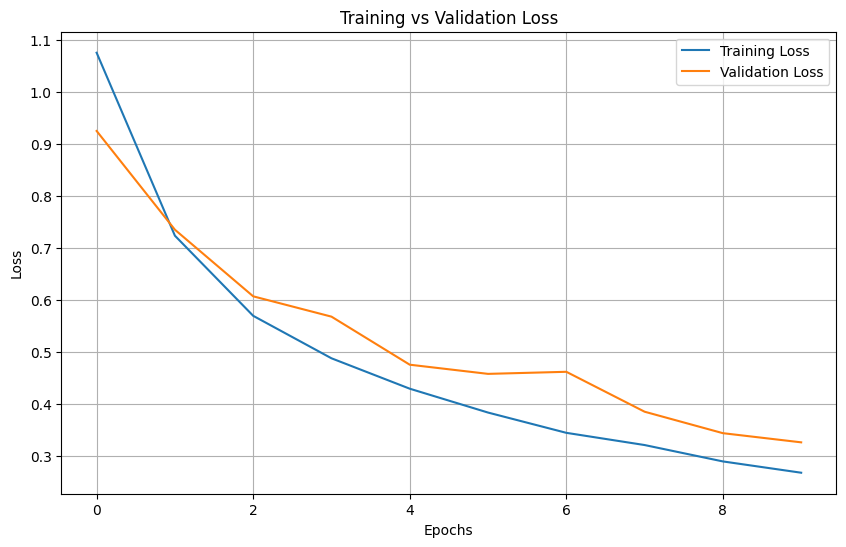

In [23]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Accuracy Test on test data

In [24]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 86.80%


Accuracy test on Test dataset

In [25]:
correct = 0
total = 0

with torch.no_grad():  # no gradients needed
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 92.24%


In [26]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
cm = confusion_matrix(all_labels, all_preds)
cm


array([[255,  39,   0,   6],
       [ 42, 198,  38,  28],
       [  5,   6, 393,   1],
       [  3,   5,   0, 292]])

<Figure size 800x600 with 0 Axes>

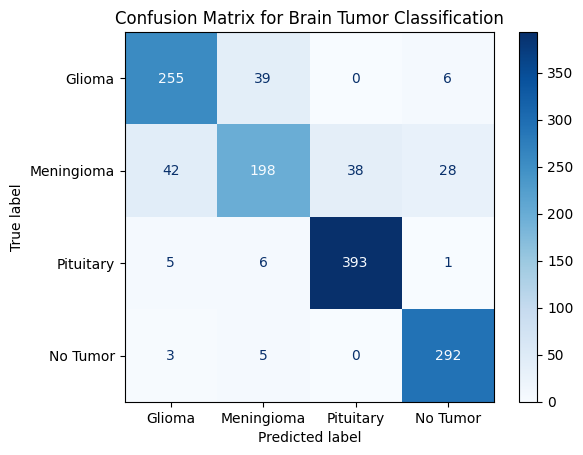

In [29]:
class_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Brain Tumor Classification")
plt.show()
